# Definition
This is the capstone project for Machine learning Nanodegree Program on Udacity. I run it on uBuntu 14.04LTS with Tensorflow installed.
## Project Overview

Document classification or document categorization is a problem in library science, information science as well as computer science. The task is to assgin a document to one or more classes. This may be done "manually" (or "intellectually") or algorithmically, and the documents to be classified may be texts, images, music, etc. Each kind of document possesses its special classification problems. Documents may be classified according to their subjects or according to other attributes (such as document type, author, printing year etc.). 

This project will focus on algorithmical methods, exactly machine learning algorithms which are widely used in information science and computer science. There are many algorithms to do classification, such as KNN, Naive Bayes, Decision Tree and etc, all of which have their advantages and disadvantages. Also there are many public text datasets online for classification, Python's NLTK package can download a lot of free texts. Here, I will apply classification algorithms on 20_newsgroup dataset from CMU Text Learning Group Data Archives, which has a collection of 20,000 messages, collected from 20 different netnews newsgroups. The news will be classified according to their contents.


## Problem Statement

The classification of 20_newsgroup dataset is a supervised problem, each piece of news belongs to one category, the goal is to extract proper features and build an effective model to assign each piece of news to the correct category. I will explore the dataset in the beginning on the training part, then extract useful keywords and build vectors of features from the texts of news, based on those vectors I will use several classfication methods to do classification, compare the efficiency  of these classifers on the testing data and choose one as final model. Finally I will validate the performance of the classifiers on different datasets and parameters.

## Metrics

As it is a multi-class classification problem with thousands of samples, I will use two metrics here:
- accuracy: to measure how well the classification algorithms perform, namely rates of samples which are correctly assigned to corresponding categories. Ideal accuracy is 100%.
- timing: how long it takes the algorithm to do classification, a scalable algorithm is expected to work fast because corpus usually includes thousands or more text files. 

# Analysis
## Data Exploration

The dataset can be aquired online with built-in sklearn tools. There are 20 categories of news in all, here I just choose 4 categories to do analysis, analogously, the other categories can be also handled in this way.

In [8]:
import numpy as np
import string
import matplotlib.pyplot as pl
from sklearn.datasets import fetch_20newsgroups
categories = ['rec.sport.baseball', 'soc.religion.christian', 'comp.graphics', 'sci.med']
twenty_train = fetch_20newsgroups(subset='train', 
                                  categories=categories,shuffle=True,random_state=11)
twenty_test = fetch_20newsgroups(subset='test', 
                                  categories=categories,shuffle=True,random_state=11)

In [2]:
print 'Number of training samples:', len(twenty_train.data)
print 'Number of testing samples:', len(twenty_test.data)

Number of training samples: 2374
Number of testing samples: 1580


In [3]:
twenty_train.target_names

['comp.graphics', 'rec.sport.baseball', 'sci.med', 'soc.religion.christian']

There are 2374 samples in training set, and 1580 in testing set. They belong to four categories including computer science, baseball, medical, religion. Let's look at the content of one text.

In [10]:
print(twenty_train.target_names[twenty_train.target[0]])

rec.sport.baseball


In [11]:
print("\n".join(twenty_train.data[0].split("\n")))

From: lyford@dagny.webo.dg.com (Lyford Beverage)
Subject: Re: Notes on Jays vs. Indians Series
Distribution: na
Organization: Data General Corporation, Research Triangle Park, NC
Lines: 22

In article <1993Apr13.202037.9485@cs.cornell.edu>, tedward@cs.cornell.edu (Edward [Ted] Fischer) writes:
|> In article <rudyC5Fr3q.1CL@netcom.com> rudy@netcom.com (Rudy Wade) writes:
|> >In article <C5FMxD.2pM@cs.dal.ca> niguma@ug.cs.dal.ca (Gord Niguma) writes:
|> >>reference to history because he certainly didn't have the best season for    
|> >>second basemen in history. He probably didn't even have as good a season as
|> >>Alomar last year.
|> >  
|> >What?  Do you have some measure (like popularity in Toronto doesn't count)
|> >that you are basing this statement on?
|> 
|> Uh, yes.  Baerga has a lot of flash, but Alomar was the better hitter
|> last year.
|> 
|> BATTERS        BA   SLG   OBP   G  AB   R   H  TB 2B 3B HR RBI  BB  SO SB CS  E
|> BAERGA,C     .312  .455  .354 161 657  92 205 299 

It looks like an email, there are a subject, an organization, an email address and a main body, the subject and content can contain some useful words in terms of classification, for example, this article mentioned 'basemen', 'hitter', terms often refer to baseball. Aside from these, there are many signs such as punctuations in the content, which may be redundant for classification.

## Exploratory Visualization

Here we'll check some statistical characteristics of the corpus through barplots, histograms and etc.

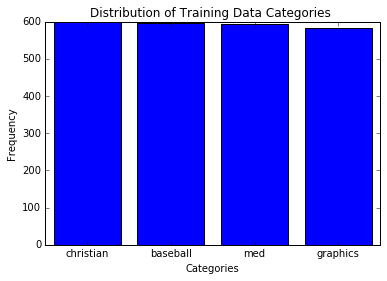

In [177]:
%matplotlib inline
from collections import Counter
left = range(4)
abbrs = ['graphics', 'baseball', 'med', 'christian']
ctgs = [abbrs[i] for i in twenty_train.target]
dicts = Counter(ctgs)
labels = [i for i,j in dicts.most_common(4)]
heights = [j for i,j in dicts.most_common(4)]
pl.bar(left=left,height=heights,tick_label=labels,align='center')
pl.title('Distribution of Training Data Categories ')
pl.xlabel('Categories')
pl.ylabel('Frequency')

The numbers of samples of each category are quite balanced, each has almost 600 pieces of news. Therefore, it is all right to use accuracy as a metric here.

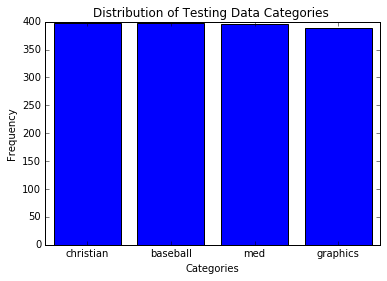

In [176]:
ctgs = [abbrs[i] for i in twenty_test.target]
dicts = Counter(ctgs)
labels = [i for i,j in dicts.most_common(4)]
heights = [j for i,j in dicts.most_common(4)]
pl.bar(left=left,height=heights,tick_label=labels,align='center')
pl.title('Distribution of Testing Data Categories ')
pl.xlabel('Categories')
pl.ylabel('Frequency')

The categories of testing data is also balanced. So the dataset has been splitted well.

In [14]:
lines_num = list()
#Record lines of each article
for i in range(len(twenty_train.data)):
    for line in twenty_train.data[i].split("\n"):
        if line.startswith('Lines: '):
            length = int(line.strip().split(': ')[1])
            lines_num.append(length)
print 'Maximum lines:', np.max(lines_num)
print 'Minimum lines:', np.min(lines_num)
print 'Median lines:', np.median(lines_num)
print 'Average lines:', np.mean(lines_num)

Maximum lines: 1566
Minimum lines: 0
Median lines: 22.0
Average lines: 36.1562235394


(0, 400)

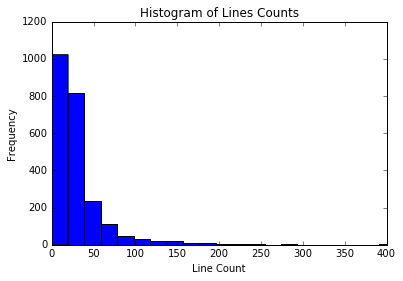

In [185]:
pl.hist(lines_num,bins=80)
pl.title('Histogram of Lines Counts')
pl.xlabel('Line Count')
pl.ylabel('Frequency')
pl.xlim([0,400])

Most articles have less than 50 lines, the median is 22, quite short articles indeed. Note: there are some articles with 0 line, perhaps they are null. We'll remove 0 line news if there are many of them, which can not provide useful information for classification.

In [17]:
print '0 line news:', lines_num.count(0)
print 'Index of 0 line news', lines_num.index(0)

 0 line news: 1
Index of 0 line news 57


Only one piece of news has 0 line, the influence is minor, and also there are only two articles have 1566 lines, very long articles, we can keep them in the corpus because they just account for a small number.

In [18]:
from textblob import TextBlob
words_count = []
words = []
for i in range(len(twenty_train.data)):
    text = twenty_train.data[i]
    blob = TextBlob(text)
    tokens = blob.tokens
    words.extend(tokens)
    words_count.append(len(tokens))
    
print 'Max word counts', np.max(words_count)
print 'Min word counts', np.min(words_count)
print 'Median word counts', np.median(words_count)

Max word counts 11002
Min word counts 26
Median word counts 232.0


(0, 2000)

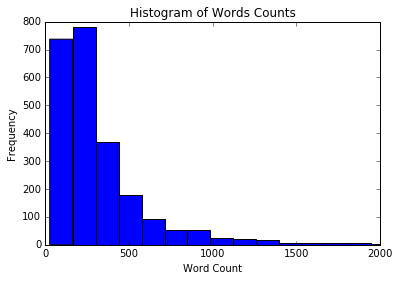

In [184]:
pl.hist(words_count,bins=80)
pl.title('Histogram of Words Counts')
pl.xlabel('Word Count')
pl.ylabel('Frequency')
pl.xlim([0,2000])

In [191]:
sum(np.array(words_count)<30)

3

Most articles have less than 500 words, max word count is 11002, min word count is 26. Note, the header of each article accounts for over 20 words, but there are only 3 articles with less than 30 words. It is not neccessary to remove them.

In [20]:
words_cleaned = []
#Remove punctuations
for word in words:
    if word in ['--', '""',"''","'"]:
        continue
    if word not in string.punctuation:
        words_cleaned.append(word)
freq = Counter(words_cleaned)
print 'Total numbers of words', len(words_cleaned)

Total numbers of words 671564


It is a huge number of words, and impossible to represent each article with all the words in the corpus. Besides, if we use all the words, maybe the model will not be generalized, it will not perform well on new corpus which has new words. So we need extract only a proper proportion of words as keywords. *Note, in this project, it is likely that the features(selected words) outnumber samples, so we need pay attention on this later*.

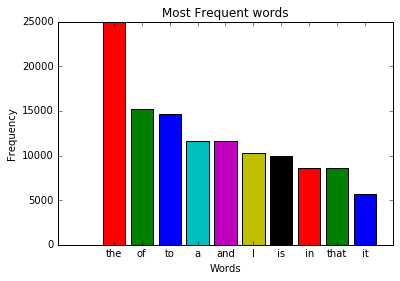

In [21]:
labels = [ i for i, j in freq.most_common(10)]
freqs = [ j for i, j in freq.most_common(10)]
left = range(10)
colors = 'rgbcmyk'
pl.bar(left=left,height=freqs,tick_label=labels,align='center',color=colors)
pl.title('Most Frequent words')
pl.xlabel('Words')
pl.ylabel('Frequency')

It is clear that the most frequent words are stop words which are commonly seen almost in every article, but without much meaning in term of classification, they can be removed to reduce the dimension of our problem.

## Algorithms and Techniques

In order to perform machine learning algorithms, first of all, I need extract features from the news, these features can be words, sentences or phrases or combination of them all. But here, I only consider using a vector of words to represent an article allowing for the computation scale. If a special word such as 'cancer' apear often in an article, it is likely to be classified as science related, but we can not simply use frequencies of words because most frequent words do not provide much useful information as the figure show above, i.e, you can find 'the' very often in each piece of news, but it gives nothing useful about the category. In fact, some specific words such as 'basemen', 'hitter', they can provide very useful information, and they do not appear often. Therefore,I'll use Tf-Idf algorithm to extract features. To avoid these potential discrepancies, itsuffices to divide the number of occurrences of each word in a document by the total number of words in the document: these new features are called tf for TermFrequencies.
Another refinement on top of tf is to down scale weights for words that occur in many documents in the corpus and are
therefore less informative than those that occur only in a smaller portion of the corpus.

In this problem, it has over 2000 training samples with four categories, a multi-class classification problem with  medium scale samples, and perhaps a very large number of features. KNN is not suitable here because of computing efficiency in high dimension. I will try Naive Bayes, Decision Tree and Deep learning methods, they can work even the feature number is large:
- Naive Bayes, Pros: only requires a small amount of training data for classification, highly scalable, used very often in text retrieval. Cons: Oversimple for certain data, it needs assumption that the value of a particular feature is independent of the value of any other feature.
- Decision Tree, pros: easy to interpret the results, scalable. Cons: the accuracy may be not excellent, prone to overfitting.
- Deep Learning, pros: can produce state-of-the-art results on various tasks. Cons: time consuming, requires good hardware environment.

The corpus of news do not provide default parameters for NB and Decision Tree models, which need tuned if necessary. But for deep learning, the number of features can determine the size of weights of hidden layers.

## Benchmark

Here we consider two factors: bias and variance.
- Bias: the ideal model should assign each testing article to the right category, namely, the accuracy 100%. The higher accuracy is, the better the algorithm is likely to be. Here I set the accuracy threshold as 90%.

- Variance: the model performance should not change on different datasets if we have trained it, try to avoid overfitting. Ideally the accuracy doesn't vary between datasets. Here I limit the accuracy difference between training and testing data is below 8%.

Furthermore, the algorithms should not take too much time if we have limited hardware resources.

# Methodology
## Data Preprocessing

I do not consider the punctuations, digits and stopwords in the contents of news. I will define a function to remove punctuations, digits.

In [47]:
#Preprocess the data by removing punctuations and digits
def preProcessor(s):
    s = s.encode('utf-8')
    s = s.translate(None, string.punctuation)
    s = s.translate(None, string.digits) 
    #s = s.lower()
    return s

Now, it's time to extract Tf-Idf vectors from original corpus, here I will use sklearn.feature_extraction package, and remove stopwords as well.

In [48]:
from sklearn.feature_extraction.text import  TfidfVectorizer
#Obtain tf-idf vector for each article
#remove stopwords in Enlgish
tfidfVectorizer = TfidfVectorizer(stop_words='english',preprocessor= preProcessor)
X_train_tfidf = tfidfVectorizer.fit_transform(twenty_train.data)
X_train_tfidf.shape

(2374, 41948)

X_train_tfidf means the TfIdf vectors for each article, and each vector consists of TfIdf values of words. There are 41948 words in all after preprocessing. Let's have a look at the words.

In [49]:
words = tfidfVectorizer.get_feature_names()
words[:10]

['AA',
 'AAA',
 'AAAA',
 'AAAI',
 'AAAIMIT',
 'AAAmajors',
 'AACC',
 'AAFFFF',
 'AAFFFFF',
 'AATCHOO']

It seems some words are typos, which can be removed due to their small frequency.

In [50]:
tfidfVectorizer = TfidfVectorizer(min_df=5, stop_words='english',preprocessor= preProcessor)
X_train_tfidf = tfidfVectorizer.fit_transform(twenty_train.data)
X_train_tfidf.shape

(2374, 8554)

In [77]:
X_train_tfidf[0,:100].toarray()

array([[ 0.        ,  0.        ,  0.09797326,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

In [76]:
type(X_train_tfidf)

scipy.sparse.csr.csr_matrix

Actually most values are zeros in the matrix, so sklearn transformed them into sparse matrix to save space.

In [51]:
words = tfidfVectorizer.get_feature_names()
words[:20]

['AA',
 'AAA',
 'AB',
 'ABOUT',
 'ABs',
 'ACM',
 'AD',
 'AI',
 'AIDS',
 'AIX',
 'AIXESA',
 'AL',
 'ALL',
 'ALLTIME',
 'ALWAYS',
 'AM',
 'AN',
 'AND',
 'ANGELS',
 'ANY']

The features of words are still far more than the training samples, but the words seems more meaningful, so I will do classification based on these words. I do not consider uppercase and lowercase here, because in certain cases, some abbreviations in uppercase have different meanings from lowercase ones.

(0, 0.015)

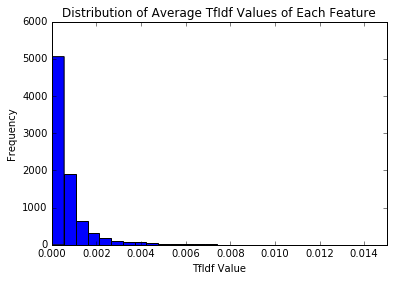

In [195]:
m = np.mean(X_train_tfidf.toarray(),axis=0)
pl.hist(m,bins=50)
pl.title('Distribution of Average TfIdf Values of Each Feature')
pl.xlabel('Avergae TfIdf Value')
pl.ylabel('Frequency')
pl.xlim([0,0.015])

(0, 0.002)

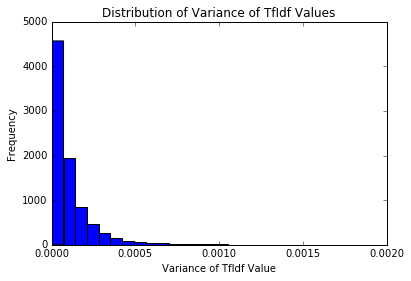

In [198]:
v = np.var(X_train_tfidf.toarray(),axis=0)
pl.hist(v,bins=50)
pl.title('Distribution of Variance of TfIdf Values')
pl.xlabel('Variance of TfIdf Value')
pl.ylabel('Frequency')
pl.xlim([0,0.002])

Both the means and variances of each feature are in similiar scales, there are no very large or extremely small figures, so we do not need normalize them.

## Implementation

I will use NB, Decison Tree algorithms based on sklearn package, and use deep learning method based on Tensorflow.

### Naive Bayesian

In [52]:
X_test_tfidf = tfidfVectorizer.transform(twenty_test.data)
import time
#Train the model
from sklearn.naive_bayes import MultinomialNB
start = time.time()
clf_nb = MultinomialNB().fit(X_train_tfidf,twenty_train.target)
#Test the model
predicted = clf_nb.predict(X_test_tfidf)
end = time.time()
print 'Accuracy of Naive Bayes: {:.3f}'.format(np.mean(predicted == twenty_test.target))
print "Training and testing time (secs): {:.3f}".format(end - start)

Accuracy of Naive Bayes: 0.946
Training and testing time (secs): 0.006


It seems NB algorithm works pretty well, which means the assumption that each feature is independent is quite strong. Also, it is very fast, only takes 0.006s.

### Decision Tree

In [53]:
from sklearn import tree
start = time.time()
clf_tree = tree.DecisionTreeClassifier()
clf_tree.fit(X_train_tfidf,twenty_train.target)
predicted = clf_tree.predict(X_test_tfidf)
end = time.time()
print 'Accuracy of Decision Tree: {:.3f}'.format(np.mean(predicted == twenty_test.target))
print "Training and testing time (secs): {:.3f}".format(end - start)

Accuracy of Decision Tree: 0.737
Training and testing time (secs): 0.578


The accuracy is not high as NB, and it takes more time to train and test.

### Deep Learning

Next I'll use Tensorflow to do deep learning based on 1-hidden layer neural networks.

In [287]:
#Transform datasets to proper forms
num_labels = 4
def reformat(dataset, labels):
  #Transform sparse matrix to array
  dataset = dataset.toarray().astype(np.float32)
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(X_train_tfidf, twenty_train.target)
test_dataset, test_labels = reformat(X_test_tfidf, twenty_test.target)
print('Training set', train_dataset.shape, train_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

('Training set', (2374, 8554), (2374, 4))
('Test set', (1580, 8554), (1580, 4))


In [299]:
import tensorflow as tf
features_num = train_dataset.shape[1]
batch_size = 32
hidden1_units = 512
graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, features_num))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables in hidden layer.
  weights_1 = tf.Variable(
    tf.truncated_normal([features_num, hidden1_units]))
  biases_1 = tf.Variable(tf.zeros([hidden1_units]))
  
  # Training computation.
  logits1= tf.matmul(tf_train_dataset, weights_1) + biases_1
  hidden1 = tf.nn.relu(logits1)
  
  #Variables in output layer
  weights_2 = tf.Variable(
    tf.truncated_normal([hidden1_units, num_labels]))
  biases_2 = tf.Variable(tf.zeros([num_labels]))

  logits2 = tf.matmul(hidden1, weights_2) + biases_2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits2, tf_train_labels))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training
  train_prediction = tf.nn.softmax(logits2)
   
  #Predictions for the testing 
  logits1= tf.matmul(tf_test_dataset, weights_1) + biases_1
  hidden1 = tf.nn.relu(logits1)
  test_prediction = tf.nn.softmax(tf.matmul(hidden1, weights_2) + biases_2)

In [304]:
num_steps = 1001
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

with tf.Session(graph=graph) as session:
  start = time.time()
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))

  end = time.time()
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
  print "Training and testing time (secs): {:.3f}".format(end - start)

Initialized
Minibatch loss at step 0: 9.194366
Minibatch accuracy: 34.4%
Minibatch loss at step 500: 0.010467
Minibatch accuracy: 100.0%
Minibatch loss at step 1000: 0.002199
Minibatch accuracy: 100.0%
Test accuracy: 72.0%
Training and testing time (secs): 44.312


Obviously overfitting happens in deep learning, and it really takes a long time to train and test. Perhaps we need more training samples or reduce dimension of features in deep learning.

From the calculation results, it is clear that NB model performs better than the other two both in terms of accuracy and time. Next, I will tune the parameters of NB and Decision Tree models.

## Refinement

I'll use grid search method to tune parameters of Naive Bayes, exactly the values of alpha. Here, I consider accuracy only because I have discussed timing above.

In [30]:
from sklearn.metrics import accuracy_score

In [54]:
# Set up the parameters we wish to tune
parameters = {'alpha':(0.01,0.05,0.1,0.5,0.8,1)}

# Make an appropriate scoring function
from sklearn.metrics import make_scorer
scoring_function = make_scorer(accuracy_score,greater_is_better=True)

# Make the GridSearchCV object
from sklearn.grid_search import GridSearchCV
cls = GridSearchCV(clf_nb, parameters, scoring_function) 
cls.fit(X_train_tfidf,twenty_train.target)

GridSearchCV(cv=None, error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': (0.01, 0.05, 0.1, 0.5, 0.8, 1), 'fit_prior': (True, False)},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(accuracy_score), verbose=0)

In [55]:
cls.best_estimator_

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [56]:
predicted = cls.predict(X_test_tfidf)
print 'Accuracy of Tuned NB: {:.3f}'.format(accuracy_score(predicted,twenty_test.target))

Accuracy of Tuned NB: 0.957


When alpha = 0.01, the model has a best accuracy of 0.957 on testing data, an improvement of default one whose accuracy is 0.946. It seems that smaller alpha can lead to a better accuracy, I'll discuss it in next part.

Let's try to tune parameters of Decision Tree classifier.

In [57]:
# Set up the parameters we wish to tune
parameters = {'max_depth':(3,4,6,8,10)}

# Make an appropriate scoring function
from sklearn.metrics import make_scorer
scoring_function = make_scorer(accuracy_score,greater_is_better=True)

# Make the GridSearchCV object
cls = GridSearchCV(clf_tree, parameters, scoring_function) 
cls.fit(X_train_tfidf,twenty_train.target)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': (3, 4, 6, 8, 10)}, pre_dispatch='2*n_jobs',
       refit=True, scoring=make_scorer(accuracy_score), verbose=0)

In [58]:
cls.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [59]:
predicted = cls.predict(X_test_tfidf)
print 'Accuracy of Tuned Decision Tree: {:.3f}'.format(accuracy_score(predicted,twenty_test.target))

Accuracy of Tuned Decision Tree: 0.591


Overfitting happens if we tune parameters of decision tree to improve training accuracy. Therefore, I will only discuss NB model later.

# Results

## Model Evaluation and Validation

In this part, I will take a look at several models' learning and testing accuracies on various subsets of training data, to check bias and variances of the models. In addition, I'll investigate NB classifier with an increasing alpha parameter on the full training set to observe how model complexity affects learning and testing accuracies.
All the results will be displayed by plots.

The function below calculates the performance of several models with varying sizes of training data. The learning and testing accuracies for each model are then plotted. 

In [60]:
def learning_curves(X_train, y_train, X_test, y_test):
     
    print "Creating learning curve graphs for alpha 0.05 0.1 0.2. . ."
    
    # Create the figure window
    fig = pl.figure(figsize=(10,8))

    # We will vary the training set size so that we have 50 different sizes
    sizes = np.rint(np.linspace(1, X_train.shape[0], 50)).astype(int)
    train_acr = np.zeros(len(sizes))
    test_acr = np.zeros(len(sizes))

    # Create four different models based on max_depth
    for k, alpha in enumerate([0.05,0.1,0.2,0.5]):
        
        for i, s in enumerate(sizes):
            
            # Setup a NB classifier 
            cls = MultinomialNB(alpha = alpha)
            
            # Fit the learner to the training data
            cls.fit(X_train[:s], y_train[:s])

            # Find the performance on the training set
            train_acr[i] = accuracy_score(y_train[:s], cls.predict(X_train[:s]))
            
            # Find the performance on the testing set
            test_acr[i] = accuracy_score(y_test, cls.predict(X_test))

        # Subplot the learning curve graph
        ax = fig.add_subplot(2, 2, k+1)
        ax.plot(sizes, test_acr, lw = 2, label = 'Testing Accuracy')
        ax.plot(sizes, train_acr, lw = 2, label = 'Training Accuracy')
        ax.legend()
        ax.set_title('alpha = %s'%(alpha))
        ax.set_xlabel('Number of Data Points in Training Set')
        ax.set_ylabel('Total Accuracy')
        ax.set_xlim([0, X_train.shape[0]])
    
    # Visual aesthetics
    fig.suptitle('Naive Bayes Learning Performances', fontsize=18, y=1.03)
    fig.tight_layout()
    fig.show()

Creating learning curve graphs for alpha 0.05 0.1 0.2. . .


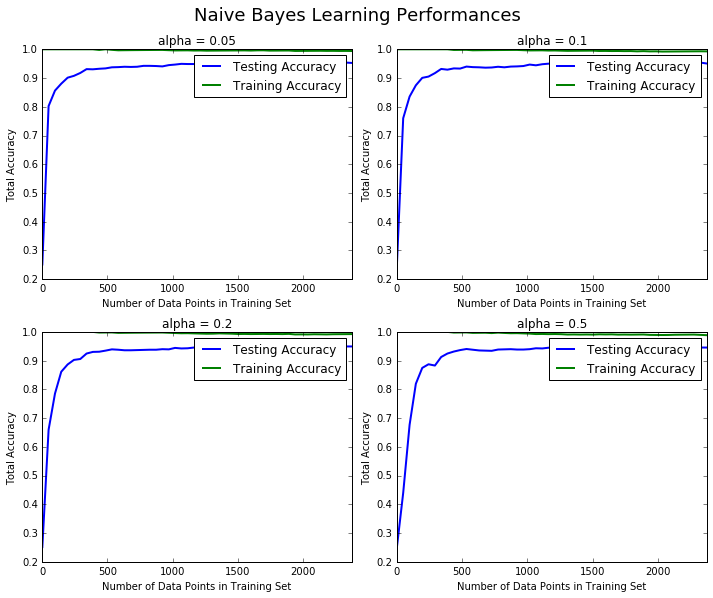

In [61]:
learning_curves(X_train_tfidf, twenty_train.target, X_test_tfidf, twenty_test.target)

Those figures indicate that NB classifier works well on those datasets in terms of variance and bias. The accuracy grows as the number of samples increases initally, When the number of samples are over 500, the accuracies become quite stable. The training accuracy reaches almost 100%, and testing accuracy can reach as high as 95%. No overfitting here. The classifier is robust in terms of sample scales.

Next function calculates the performance of the model as model complexity increases. The learning and testing accuracies are then plotted.     

In [62]:
def model_complexity(X_train, y_train, X_test, y_test):
    
    print "Creating a model complexity graph. . . "

    # We will vary the alpha of a NB model from 0 to 2
    alpha = np.arange(0.01, 1,0.02)
    train_acr = np.zeros(len(alpha))
    test_acr = np.zeros(len(alpha))

    for i, d in enumerate(alpha):
        # Setup a Multi nomial NB classifer so that it learns with alpha d
        cls = MultinomialNB(alpha = d)

        # Fit the learner to the training data
        cls.fit(X_train, y_train)

        # Find the performance on the training set
        train_acr[i] = accuracy_score(y_train, cls.predict(X_train))

        # Find the performance on the testing set
        test_acr[i] = accuracy_score(y_test, cls.predict(X_test))

    # Plot the model complexity graph
    pl.figure(figsize=(7, 5))
    pl.title('Naive Bayes Classification Complexity Performance')
    pl.plot(alpha, test_acr, lw=2, label = 'Testing Accuracy')
    pl.plot(alpha, train_acr, lw=2, label = 'Training Accuracy')
    pl.legend()
    pl.xlabel('Alpha')
    pl.ylabel('Total Accuracy')
    pl.show()

Creating a model complexity graph. . . 


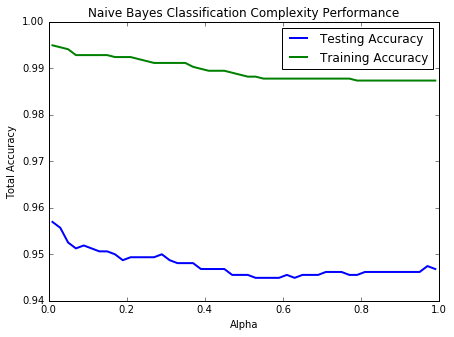

In [63]:
model_complexity(X_train_tfidf, twenty_train.target, X_test_tfidf, twenty_test.target)

As the alpha increases, the accuracies of training dataset and testing dataset go down slowly. Then after 0.4, the accuracies seem to be stable. The testing accuracy is around 95%, and when alpha is close to zero, it has large accuracy. The differences between training dataset and testing dataset are small, no overfitting here. 

Above all, NB classifier is quite robust to different training datasets and alpha. I will set alpha= 0.01 as the parameter of our final model.

## Justification

As we have analysed above, NB performs well on the classification tasks in terms of both bias and variance. The accuracy of classification can reach 95%, and the variance is also small, that means the model generalizes well.

Furthermore, the NB model assumes independence between features, I'd like to check whether those features are independent in terms of linear relationship. Allowing for the scale of the features, we just show the descriptive statistics of the correlation coefficients.

In [140]:
cor = np.cov(X_train_tfidf.toarray())

In [139]:
print 'Max Correlation Coefficient:{:.5f}'.format(np.max(cor))
print 'Min Correlation Coefficient:{:.5f}'.format(np.min(cor))
print 'Median Correlation Coefficient:{:.5f}'.format(np.median(cor))
print 'Mean Correlation Coefficient:{:.5f}'.format(np.mean(cor))

Max Correlation Coefficient:0.00012
Min Correlation Coefficient:-0.00000
Median Correlation Coefficient:0.00000
Mean Correlation Coefficient:0.00000


From the statistics above, it is true that those words are linearly independent in terms of TfIdf values.

Let's look back at our original datasets, many datasets of other categories remain left, I can use them to test my model. And I will choose datasets of another four categories to validate this model.

In [64]:
categories_new= ['rec.motorcycles', 'talk.politics.misc', 'comp.windows.x', 'sci.space']
twenty_train_new = fetch_20newsgroups(subset='train', 
                                  categories=categories_new,shuffle=True,random_state=11)
twenty_test_new = fetch_20newsgroups(subset='test', 
                                  categories=categories_new,shuffle=True,random_state=11)
#Vectorize the texts
tfidfVectorizer_new = TfidfVectorizer(min_df=5, stop_words='english',preprocessor= preProcessor)
X_train_tfidf_new = tfidfVectorizer_new.fit_transform(twenty_train_new.data)
X_test_tfidf_new = tfidfVectorizer_new.transform(twenty_test_new.data)

#Train the model
start = time.time()
clf_nb_new = MultinomialNB(alpha=0.01).fit(X_train_tfidf_new,twenty_train_new.target)
#Test the model
predicted = clf_nb_new.predict(X_test_tfidf_new)
end = time.time()
print 'Accuracy of Naive Bayes: {:.3f}'.format(np.mean(predicted == twenty_test_new.target))
print "Training and testing time (secs): {:.3f}".format(end - start)

Accuracy of Naive Bayes: 0.966
Training and testing time (secs): 0.006


The model still performs quite well. The accuracy is above 0.95 and the timing is very small. So this model can classify these articles precisely and quickly.

# Conclusion

## Free-Form Visualization

As we have thousands of features, we may wonder whether it is possible to reduce the dimension of the features, and next we'll adopt PCA on the given dataset.

In [141]:
from sklearn.decomposition import PCA
pca = PCA()
newData = pca.fit(X_train_tfidf.toarray())

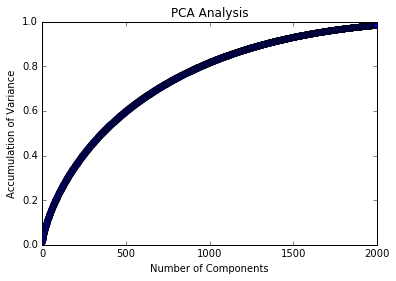

In [157]:
x= np.arange(2000)
pl.plot(x,np.cumsum(pca.explained_variance_ratio_[:2000]),'-o')
pl.xlabel('Number of Components')
pl.ylabel('Accumulation of Variance')
pl.title('PCA Analysis')

From the figure above, it is clear that 2000 components can contain almost all the variance of original features, and it is possible to use PCA to reduce the dimension of features if we can accept certain loss of accuracy.

In addition, I will explore how the features influence the classification results, to check certain words are related to articles of certan categories. I will try to find out some of important words for each category.

In [65]:
clf_nb = MultinomialNB(alpha=0.01).fit(X_train_tfidf,twenty_train.target)
weights = np.exp(clf_nb.feature_log_prob_)
weights.shape

(4, 8554)

In [91]:
def BarImportantWords(weights=None,words=None,selected_num=20):
    if weights is None or words is None:
        print 'No weights or words!'
    else:
        fig = pl.figure(figsize=(10,15))
        for i in range(len(categories)):
            important_feature_index = np.argsort(weights[i,:])[-selected_num:]
            important_words = [words[j] for j in important_feature_index]
            important_weights = [weights[i, j] for j in important_feature_index]
            ax = fig.add_subplot(4, 1, i+1)
            ax.bar(left=range(len(important_words)),height=important_weights,
                   tick_label=important_words,align='center',color=colors)
            ax.set_title('Barplot Of Important Words of %s'%(twenty_train.target_names[i]))
            #ax.set_xlabel('Number of Data Points in Training Set')
            ax.set_ylabel('Tf-Idf')
            #ax.set_xlim([0, X_train.shape[0]])
            
        fig.suptitle('Barplots Of Important Words', fontsize=18, y=1.03)
        fig.tight_layout()
        fig.show()
            

Weights bars of important words in each categoriy will be displayed.

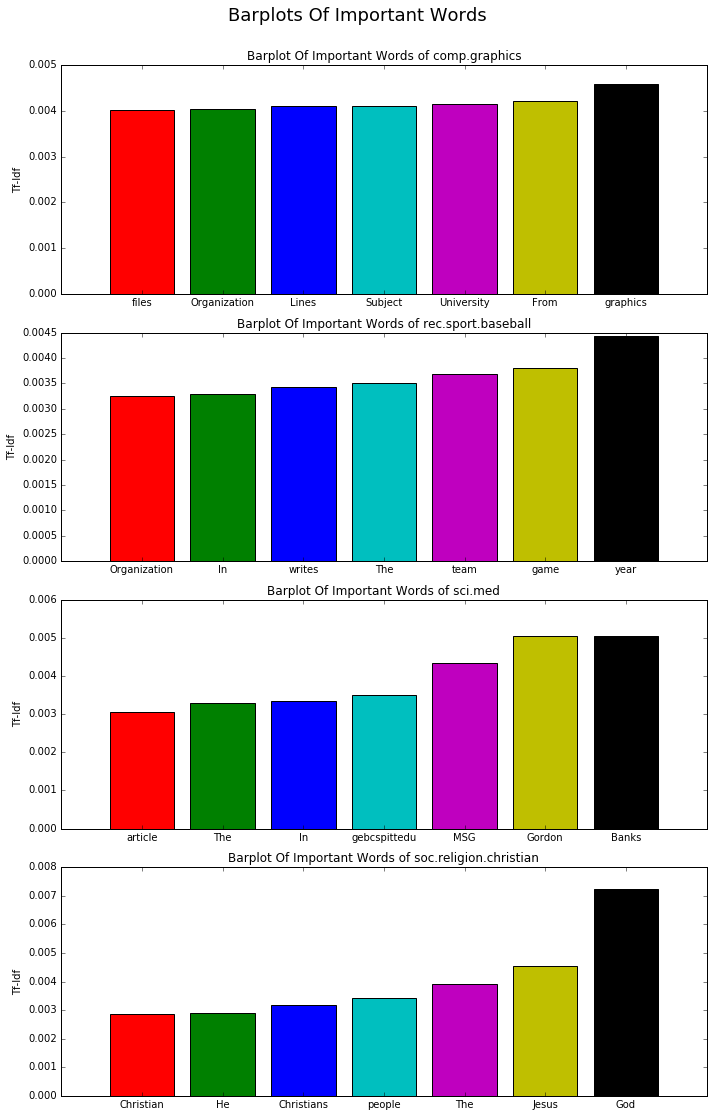

In [158]:
BarImportantWords(weights,words,selected_num=7)

It shows that these listed important words are related to certain categories, which is coherent to the classification. For example, in the first figure, 'graphics' is very important for 'comp.graphics', and in the last figure, 'God', 'Christians', 'Jesus' point to religion. But there are also stopwords such as 'The', 'From', perhaps the default English stopwords in sklearn package are not sufficient, if neccessary we can enlarge the stopwords vocabulary.

## Reflection

This project is to solve a multi-class document classification problem. I hdownloaded 20newsgroups datasets, analysed the characteristcs of the datasets, extracted features using TfIdf from the corpus. The features outnumbers training samples, so I applied Naive Bayes, Decision Tree and Deep learning classifier to the datasets, and found that NB performed best in terms of accuracy and timing on the testing datasets. Then I tuned parameters of NB classifier to improve the performance with grid search method. Afterwards, I analysed robustness of NB by exploring models' learning and testing accuracies on various subsets of training data, and comparing accuracies as changing values of alpha. NB classifier has balanced bias and variance, it generalized well on different datasets if the sample number is over 500, and the variance of classifier is not sensitive to alpha. In addition, I validated the classifer on other catergories of datasets, it still worked well. Finally, I listed weights and words of import features of each category, which were coherent in terms of real world meanings.

## Improvement

In this project, I did not transform all the words into upper or lowercase, neither did I consider different forms of the same words, for example, 'Christian', 'Christians', 'christian' are the same in meaning, if I combine them into one word, I can reduce the redundance of features and improve efficiency of the model. Apart from these, I can also enlarge the stopwords vocabulary to reduce redundance. Furthermore, if I take phrases such bigrams or trigrams into consideration, i.e., 'big data', 'machine learning', it will be likely to increase the classification accuracy, but require more computing capabilities and memories.

# Reference

1. Naive Bayes Classifier: https://en.wikipedia.org/wiki/Naive_Bayes_classifier
2. Deep Learning: https://en.wikipedia.org/wiki/Deep_learning
3. Decision Tree: https://en.wikipedia.org/wiki/Decision_tree
4. Document Classification: https://en.wikipedia.org/wiki/Document_classification
5. Deep Learning Class: https://cn.udacity.com/course/deep-learning--ud730
6. scikit-learn userguide: scikit-learndevelopers, Release0.16.1.